# Plot data sets per source for CTA

This notebook needs the generated pseudo-datasets from `Create_CTA_datasets.ipynb`, produces maps and spectrum as seen by CTA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from astropy.coordinates import SkyCoord
import astropy.units as u

from gammapy.datasets import MapDataset
from gammapy.maps import MapAxis

from regions import CircleSkyRegion

from os import makedirs
from os import path

import sys

sys.path.append("../src")

from flux_utils import SourceModel
from configure_analysis import AnalysisConfig
analysisconfig = AnalysisConfig()

import plot_utils

plot_utils.mpl_settings()

In [2]:
# Get configuration for plots from configfile
source_name = analysisconfig.get_source()

livetime = analysisconfig.get_value("livetime", "cta_datasets") * u.h
wobble_offset = analysisconfig.get_value("offset", "cta_datasets") * u.deg
point_dirs = analysisconfig.get_value("pointings", "cta_datasets")

emin = analysisconfig.get_value("emin", "cta_datasets")
emax = analysisconfig.get_value("emax", "cta_datasets")
nebin = analysisconfig.get_value("nebin", "cta_datasets")

modeltype = analysisconfig.get_value("modeltype", "cta_only_sources")

model = SourceModel(source_name, modeltype)

print("Plotting", source_name, "flux type", model.fluxtype)

Plotting VelaX flux type PD


In [3]:
# get positions and pointings for source
pointings = model.position.directional_offset_by(point_dirs * u.deg, wobble_offset)

In [4]:
# reading pseudo-dataset
datasetname = analysisconfig.get_file("cta/pseudodata/CTA_{}_{}{}_p4.fits.gz".format(
    source_name, int(livetime.value), livetime.unit)
)
stacked_dataset = MapDataset.read(datasetname)

CPU times: user 5.92 s, sys: 142 ms, total: 6.06 s
Wall time: 6.07 s


Counting and stacking ...

In [5]:
npred_bkg = stacked_dataset.npred()  # Predicted background counts

In [6]:
stacked_dataset.models.append(model.get_fluxmodel)
npred_sum = stacked_dataset.npred()  # Predicted signal and background counts
npred_src = npred_sum - npred_bkg

## CTA realization skymap for counts

The following part creates counts map of a pseudo CTA data set based on given model. The counts are Poisson-
randomised based on the model prediction for Vela X (modelled as a disk with radius 0.8$^{\circ}$) and the residual hadronic background, summed over all energies and smoothed with a 0.05$^{\circ}$ Gaussian. The blue circle and ‘×’ markers denote the source and pointing positions, respectively.
The white dashed circle shows the source region for which the counts spectra shown in the figure below have been extracted. (Fig. 7)

In [7]:
stacked_dataset.fake(random_state=137)

In [8]:
counts = stacked_dataset.counts
max_counts = counts.sum_over_axes().data.max()

In [9]:
src_region = CircleSkyRegion(
    model.position,
    (model.get_radius + 0.5 * u.deg),
)
src_reg_mask = counts.geom.to_image().region_mask([src_region])

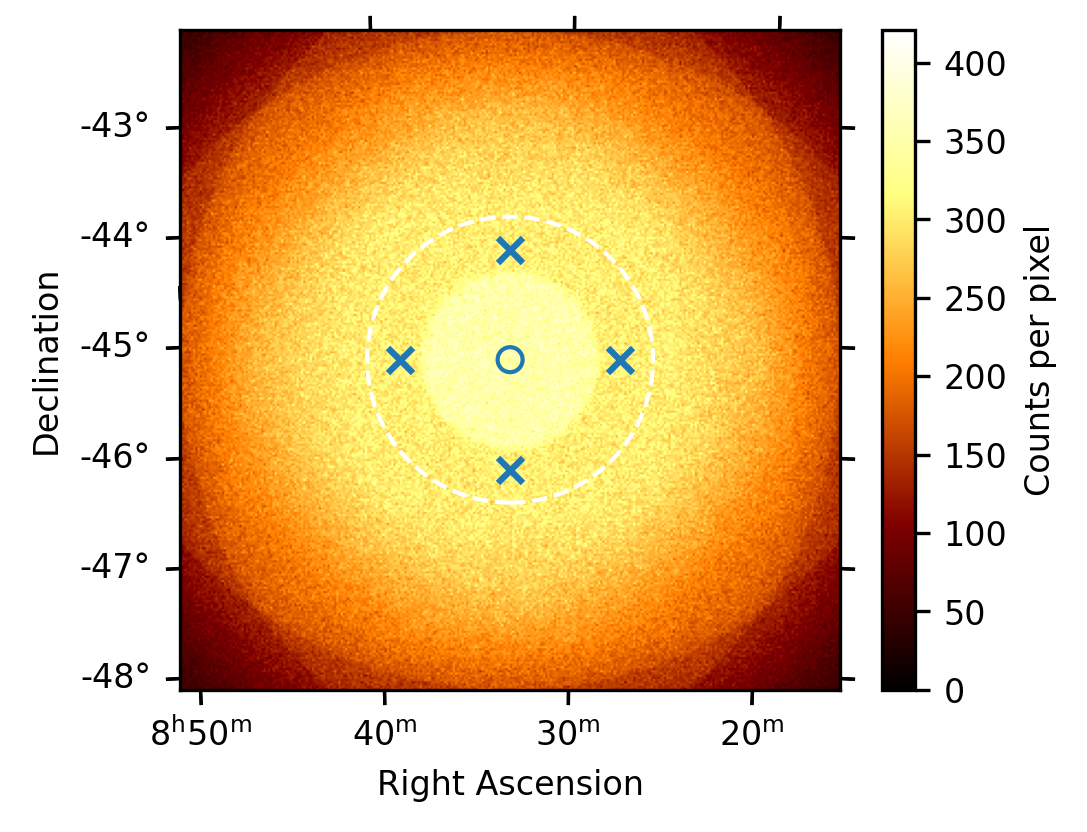

In [10]:
fig_width = 8.8 / 2.54
fig_height = 2.75

cmap = cm.afmhot
norm = colors.Normalize(vmin=0, vmax=max_counts)
data = counts.sum_over_axes().data

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
fig, ax, cbar = counts.sum_over_axes().plot(add_cbar=True)
im = ax.imshow(data, cmap=cmap, norm=norm)

ax.scatter(
    model.position.ra.value,
    model.position.dec.value,
    marker="o",
    fc="None",
    ec="tab:blue",
    transform=ax.get_transform("world"),
)
ax.scatter(
    pointings.ra.value,
    pointings.dec.value,
    marker="x",
    color="tab:blue",
    transform=ax.get_transform("world"),
    zorder=4,
)
src_reg_pix = src_region.to_pixel(ax.wcs)
src_reg_pix.plot(ax=ax, ec="w", ls="--")


cbar.update_normal(cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label("Counts per pixel")
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.17, top=0.97)

if analysisconfig.get_value("write_CTA_model_plots", "io"):
    for form in ["png", "pdf"]:
        fig.savefig(
            analysisconfig.get_file("cta/plots/map_CTA_counts_{}_{}.{}".format(modeltype, source_name, form))
        )

## CTA realization skymap for signal and background

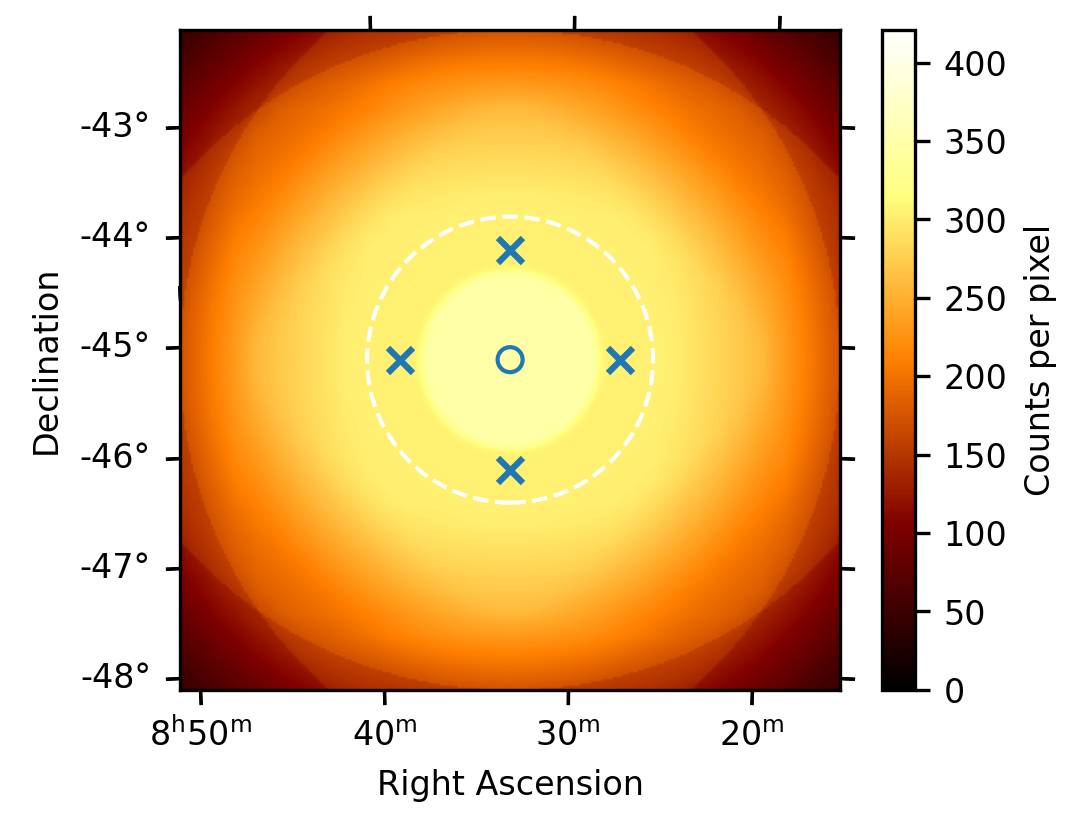

In [11]:
fig_width = 8.8 / 2.54
fig_height = 2.75

data = npred_sum.sum_over_axes().data

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
fig, ax, cbar = npred_sum.sum_over_axes().plot(fig=fig, add_cbar=True)
im = ax.imshow(data, cmap=cmap, norm=norm)
ax.scatter(
    model.position.ra.value,
    model.position.dec.value,
    marker="o",
    fc="None",
    ec="tab:blue",
    transform=ax.get_transform("world"),
)
ax.scatter(
    pointings.ra.value,
    pointings.dec.value,
    marker="x",
    color="tab:blue",
    transform=ax.get_transform("world"),
    zorder=4,
)
src_reg_pix = src_region.to_pixel(ax.wcs)
src_reg_pix.plot(ax=ax, ec="w", ls="--")


cbar.update_normal(cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label("Counts per pixel")

plt.subplots_adjust(left=0.15, right=0.95, bottom=0.17, top=0.97)

if analysisconfig.get_value("write_CTA_model_plots", "io"):
    for form in ["png", "pdf"]:
        fig.savefig(
            analysisconfig.get_file("cta/plots/map_CTA_npred_{}_{}.{}".format(modeltype, source_name, form))
        )

## CTA spectrum for source

Counts spectra for the ssource, extracted for a region encompassing the source (cf. Fig. 7). The coloured lines denote the number of predicted counts within the source region for an observation time of 200 hours. The black data points visualise one random Poisson realisation, drawn from the model predictions. (Fig. 8)

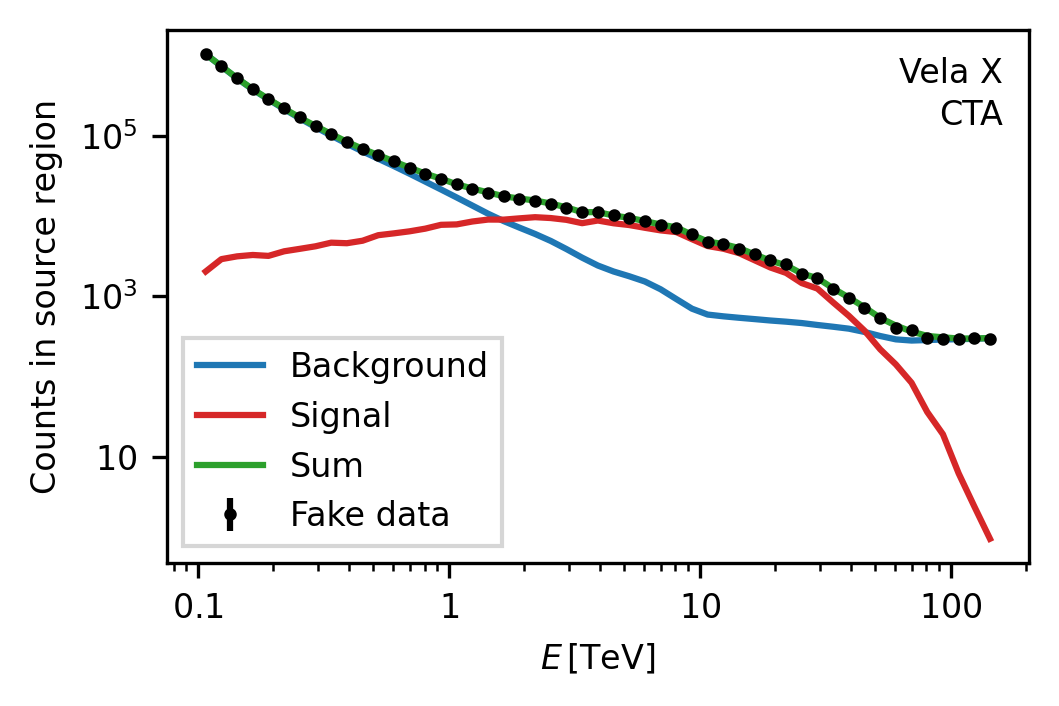

In [12]:
fig_width = 8.8 / 2.54
ax_width = 0.83
fig_height = 2.2
ax_height = fig_width * ax_width / 1.618 / fig_height  # golden ratio

e_edges = np.logspace(emin, emax, nebin) * u.TeV
energy_reco_axis = MapAxis.from_edges(e_edges, unit="TeV", name="energy", interp="log")

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.add_axes([0.16, 0.18, ax_width, ax_height])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$E\,[\mathrm{TeV}]$")
ax.set_ylabel("Counts in source region")

ax.plot(
    energy_reco_axis.center.value,
    npred_bkg.data[:, src_reg_mask].sum(axis=1),
    color="tab:blue",
    label="Background",
)
ax.plot(
    energy_reco_axis.center.value,
    npred_src.data[:, src_reg_mask].sum(axis=1),
    color="tab:red",
    label="Signal",
)
ax.plot(
    energy_reco_axis.center.value,
    npred_sum.data[:, src_reg_mask].sum(axis=1),
    color="tab:green",
    label="Sum",
)
ax.errorbar(
    energy_reco_axis.center.value,
    counts.data[:, src_reg_mask].sum(axis=1),
    xerr=None,
    yerr=np.sqrt(counts.data[:, src_reg_mask].sum(axis=1)),
    linestyle="None",
    marker="o",
    markersize=2,
    color="k",
    label="Fake data",
    zorder=8,
)

ax.text(
    0.97,
    0.95,
    plot_utils.source_name_labels[source_name],
    ha="right",
    va="top",
    transform=ax.transAxes,
)
ax.text(0.97, 0.87, "CTA", ha="right", va="top", transform=ax.transAxes)

plot_utils.format_log_axis(ax.xaxis)
plot_utils.format_log_axis(ax.yaxis)

ax.legend(loc="lower left")

if analysisconfig.get_value("write_CTA_model_plots", "io"):
    for form in ["png", "pdf"]:
        fig.savefig(
            analysisconfig.get_file("cta/plots/counts_reg_CTA_{}_{}.{}".format(modeltype, source_name, form))
        )